# Task

As a data analyst there is plenty of opportunity to improve processes or suggest new ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".

**More specifially, do the following:**

1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column "ocean_proximity", then you only have numeric columns which will simplify your analysis. Remember, this is a POC!
3. Split your data into train and test set. 
4. Create a pipeline containing a SimpleImputer [ SimpleImputer(strategy="median") ] and a std_scaler (and fit-transform your train set). 

5. Use GridSearchCV when choosing your model. You will look at a RandomForestRegressor with 2, 5, 10 or 100 estimators. More specifically, use the following code: 

```python
param_grid = [{'n_estimators': [2, 5, 10, 100]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_feature, train_label)
```

6. Evaluate your model on the test set using the mean squared error as the metric. Conclusions? (Remember, you have fitted your pipeline above so now you just transform your test set without fitting your pipeline on it, else it is "cheating".)

7. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

# POC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# Below, set your own path where you have stored the data file. 
housing = pd.read_csv(r'C:\Users\olofs\OneDrive\Skrivbord\Machine_Learning\Lecture_2_house_prices\housing.csv')

## EDA

In [3]:
housing.head()

# Shows the basic structure of the data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()
housing.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
print(housing["median_house_value"].value_counts())
print(housing["median_income"].value_counts())

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64
3.1250     49
15.0001    49
2.8750     46
2.6250     44
4.1250     44
           ..
4.0774      1
4.1767      1
6.1814      1
6.4319      1
2.0943      1
Name: median_income, Length: 12928, dtype: int64


array([[<Axes: title={'center': 'median_income'}>]], dtype=object)

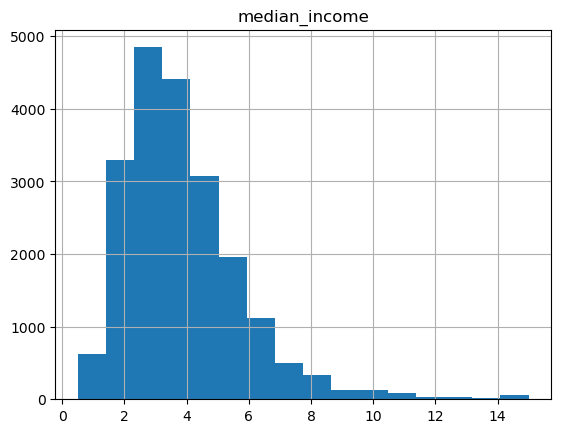

In [6]:
housing.hist('median_income', bins=16)

In [7]:
housing_2=housing.drop(['ocean_proximity'], axis=1)
housing_2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

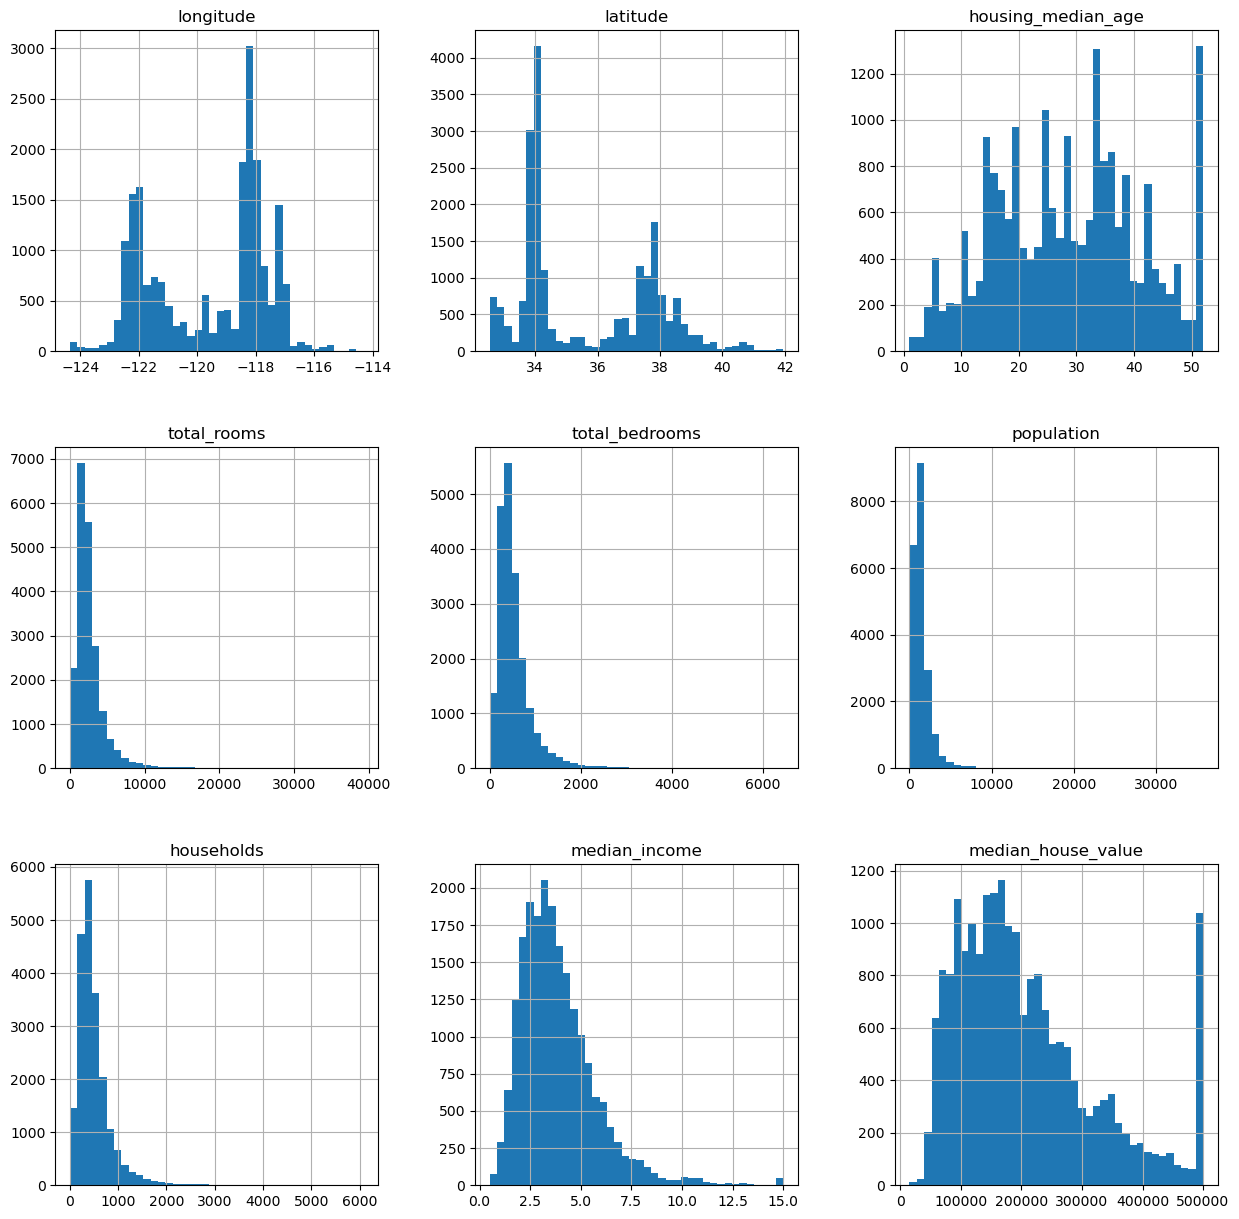

In [8]:
housing_2.hist(bins=40, figsize=(15,15))

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>,
        <Axes: xlabel='households', ylabel='median_house_value'>,
        <Axes: xlabel='population', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>,
        <Axes: xlabel='households', ylabel='median_income'>,
        <Axes: xlabel='population', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='housing_median_age', ylabel='housing_median_age'>,
        <Axes: xlabel='households', ylabel='housing_median_age'>,
        <Axes: xlabel='population', ylabel

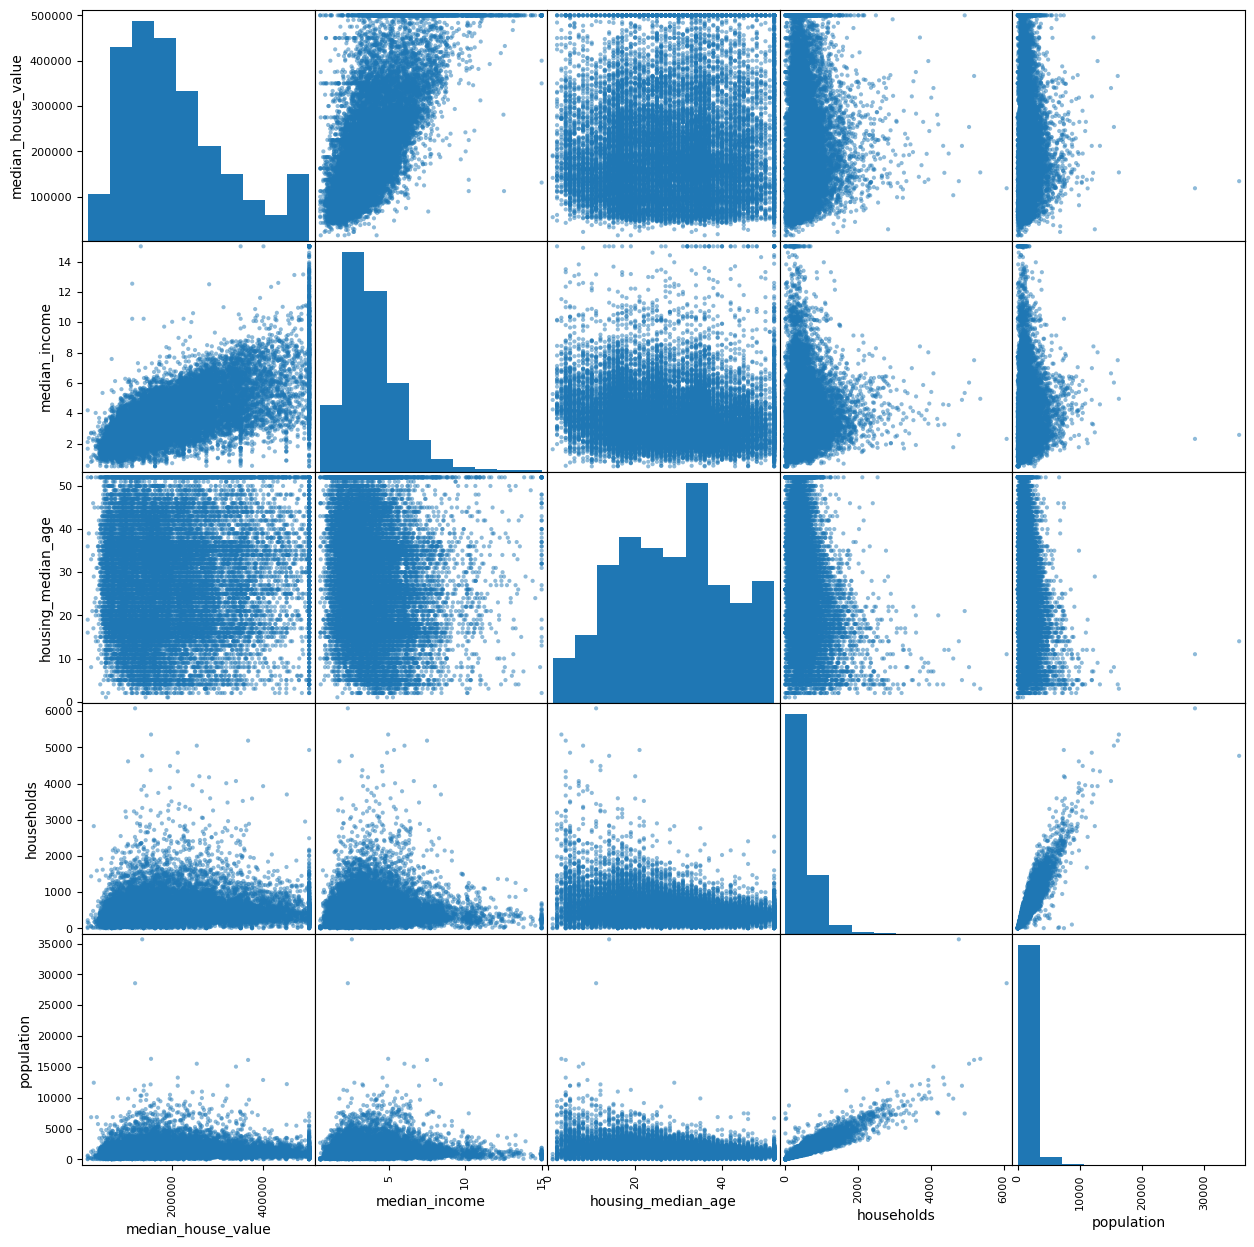

In [9]:
from pandas.plotting import scatter_matrix as sm

attributes = ['median_house_value', 'median_income', 'housing_median_age', 'households', 'population']
sm(housing_2[attributes], figsize=(15,15))

In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='mean')



In [11]:
# imputer.fit(housing_2)

In [12]:
# print(imputer.statistics_)
# print(housing_2.mean().values)

In [13]:
# impuded_housing = imputer.transform(housing_2)

In [14]:
# housing_2 = pd.DataFrame(impuded_housing, columns= housing_2.columns, index=housing_2.index)
# housing_2.head()


In [15]:
# housing_2.corr()['median_house_value'].sort_values(ascending=False)
# Find out what attribute correlates the best with median house value

<Axes: >

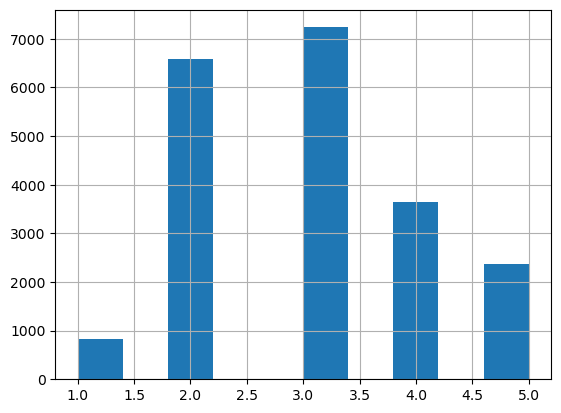

In [16]:
housing_2["income_cat"] = pd.cut(housing_2["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])
housing_2["income_cat"].hist()


In [17]:
housing_2['income_cat'].value_counts() / len(housing_2)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split
X = housing_2.drop(['median_house_value'], axis=1)
y = housing_2['median_house_value']

X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X, y, test_size=0.2, random_state=10)

# Check that propotions are right
print(len(X_test_set)/len(housing_2), len(X_train_set)/len(housing_2))
print(len(y_test_set)/len(housing_2), len(y_train_set)/len(housing_2))



0.2 0.8
0.2 0.8


In [19]:
X_train_set.info()
X_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12346 to 17673
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16346 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   income_cat          16512 non-null  category
dtypes: category(1), float64(8)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 20303 to 6581
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           4128 non-null   float64 
 1   latitude            

In [20]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# # initiate scaler
# scale = StandardScaler()

# # Fit_transform the data 
# scaled_housing = scale.fit_transform(X_train_set)

# # Check that variance is 1 and mean 0
# print("{:.6f}".format(scaled_housing.var()))
# print("{:.6f}".format(scaled_housing.mean()))


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

# Pipeline instanciates all classes. 
pipe = Pipeline([
    ("handle_values", SimpleImputer(strategy='mean')),
    ("scaling", StandardScaler())
])

# Fit_transform on all steps

# Add predictor at the end
# pipe = Pipeline([
#     ("handle_values", SimpleImputer(strategy='mean')),
#     ("scaling", StandardScaler()),
#     ("lasso", Lasso())
# ])
# # Fit on the pipeline. Fit_transform on SI and SC and fit on Lasso
# pipe.fit(X_train_set)

# # Predict using the pipeline. X_test_set is transformed using SI and SC, predicted using Lasso
# y_pred = pipe.predict(X_test_set)

# # compare y_test_set and y_pred




scaled_housing_pipeline = pipe.fit_transform(X_train_set)

# ypred = pipe.predict(X_test_set, y_test_set)
# Fiting here is th scale the data, not to train a model, since no model is in the pipeline

# Create dataframe of the scaled data
dfscaled = pd.DataFrame(scaled_housing_pipeline)

# Check that var and mean are 1 and 0
print("{:.6f}".format(scaled_housing_pipeline.var()))
print("{:.6f}".format(scaled_housing_pipeline.mean()))

# Var compresses the data, mean decides where we are

# Check that missing values were replaced
dfscaled.info()

1.000000
0.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16512 non-null  float64
 1   1       16512 non-null  float64
 2   2       16512 non-null  float64
 3   3       16512 non-null  float64
 4   4       16512 non-null  float64
 5   5       16512 non-null  float64
 6   6       16512 non-null  float64
 7   7       16512 non-null  float64
 8   8       16512 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [2, 5, 10, 100, 150]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(scaled_housing_pipeline, y_train_set)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [2, 5, 10, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.308105,0.021179,0.012501,0.003077,2,{'n_estimators': 2},-3.777012e+09,-4.205006e+09,-3.927036e+09,-3.969685e+09,1.773113e+08,5,-1.147226e+09,-1.184068e+09,-1.128763e+09,-1.153352e+09,2.298983e+07
1,0.762976,0.011979,0.009651,0.002323,5,{'n_estimators': 5},-2.817450e+09,-3.173251e+09,-3.235424e+09,-3.075375e+09,1.841382e+08,4,-6.438661e+08,-6.965322e+08,-6.835438e+08,-6.746474e+08,2.240223e+07
2,1.495716,0.033067,0.016724,0.000851,10,{'n_estimators': 10},-2.664940e+09,-2.820380e+09,-2.850259e+09,-2.778526e+09,8.123881e+07,3,-5.054598e+08,-5.101384e+08,-5.152092e+08,-5.102691e+08,3.981244e+06
3,9.029394,0.056101,0.110733,0.010830,100,{'n_estimators': 100},-2.437938e+09,-2.576040e+09,-2.549262e+09,-2.521080e+09,5.979818e+07,2,-3.587686e+08,-3.564366e+08,-3.545710e+08,-3.565921e+08,1.717186e+06
4,13.550866,0.199423,0.207795,0.013842,150,{'n_estimators': 150},-2.420853e+09,-2.568224e+09,-2.543466e+09,-2.510848e+09,6.443354e+07,1,-3.532060e+08,-3.523793e+08,-3.493171e+08,-3.516341e+08,1.672823e+06


In [29]:
X_test_transformed = pipe.transform(X_test_set)
ypred = grid_search.predict(X_test_transformed)

# Get RMSE
mean_squared_error(y_test_set, ypred, squared=False)

49125.96461158422

In [30]:
print(y_test_set)
print(ypred)

20303    167400.0
16966    354100.0
10623    160200.0
6146     140800.0
2208     107800.0
           ...   
3263     106300.0
11694    393700.0
1729     131300.0
5087      92300.0
6581     500001.0
Name: median_house_value, Length: 4128, dtype: float64
[254306.02       323638.66666667 261392.66666667 ... 155278.
 107390.66666667 455963.86      ]
